In [ ]:
'''
 * Copyright (c) 2005 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''



## Variable Learning Rate Backpropagation (VLBP)

In this section, we explore the concept of variable learning rates, which can potentially speed up convergence during training. The idea is to adjust the learning rate based on the performance of the neural network.

## Key Concepts

1. **Learning Rate Adjustment**: 
   - If the squared error (over the entire training set) increases by more than a set percentage $ \zeta $ (typically 1% to 5%) after a weight update:
     - Discard the weight update.
     - Multiply the learning rate by a factor $ \rho $ (where $ 0 < \rho < 1 $).
     - Set the momentum coefficient $ \gamma $ (if used) to zero.
   
2. **Accepting Weight Updates**:
   - If the squared error decreases after a weight update:
     - Accept the weight update.
     - Multiply the learning rate by a factor $ \eta $ (where $ \eta > 1 $).
     - If $ \gamma $ was previously set to zero, reset it to its original value.
   
3. **Minor Error Changes**:
   - If the squared error increases by less than $ \zeta $:
     - Accept the weight update but keep the learning rate unchanged.
     - If $ \gamma $ was previously set to zero, reset it to its original value.

## Example Illustration

To illustrate VLBP, consider the trajectory for the algorithm using the following parameters:
- $ \eta = 1.05 $
- $ \rho = 0.7 $
- $ \zeta = 4\% $

The resulting behavior is that the learning rate tends to increase when the trajectory is traveling in a straight line with consistently decreasing error. Conversely, when the trajectory enters a narrow valley, the learning rate is reduced to prevent oscillations and increase stability.

### Error and Learning Rate Dynamics

As shown in the following figures:
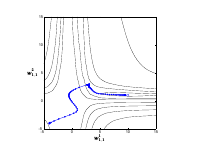

Figure.11 Variable Learning Rate Trajectory

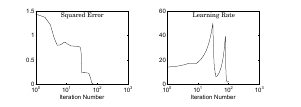

Figure.12 Convergence Characteristics of Variable Learning Rate

- **Figure.11** demonstrates the trajectory of the VLBP algorithm.
- **Figure.12** shows the squared error and learning rate over iteration numbers.

The learning rate adjusts dynamically:
- Increases when moving straight towards a minimum.
- Decreases upon reaching narrow valleys or when overshooting minima.

### Challenges with VLBP

While VLBP can provide faster convergence, there are drawbacks:
1. **Parameter Sensitivity**: Multiple parameters (e.g., $ \zeta, \rho, \gamma $) need to be set, which may require fine-tuning.
2. **Failure to Converge**: In some cases, VLBP might fail to converge when standard backpropagation (SDBP) would have found a solution.

## Summary

The variable learning rate backpropagation algorithm adapts the learning rate dynamically during training, potentially accelerating convergence and providing a more efficient learning process.



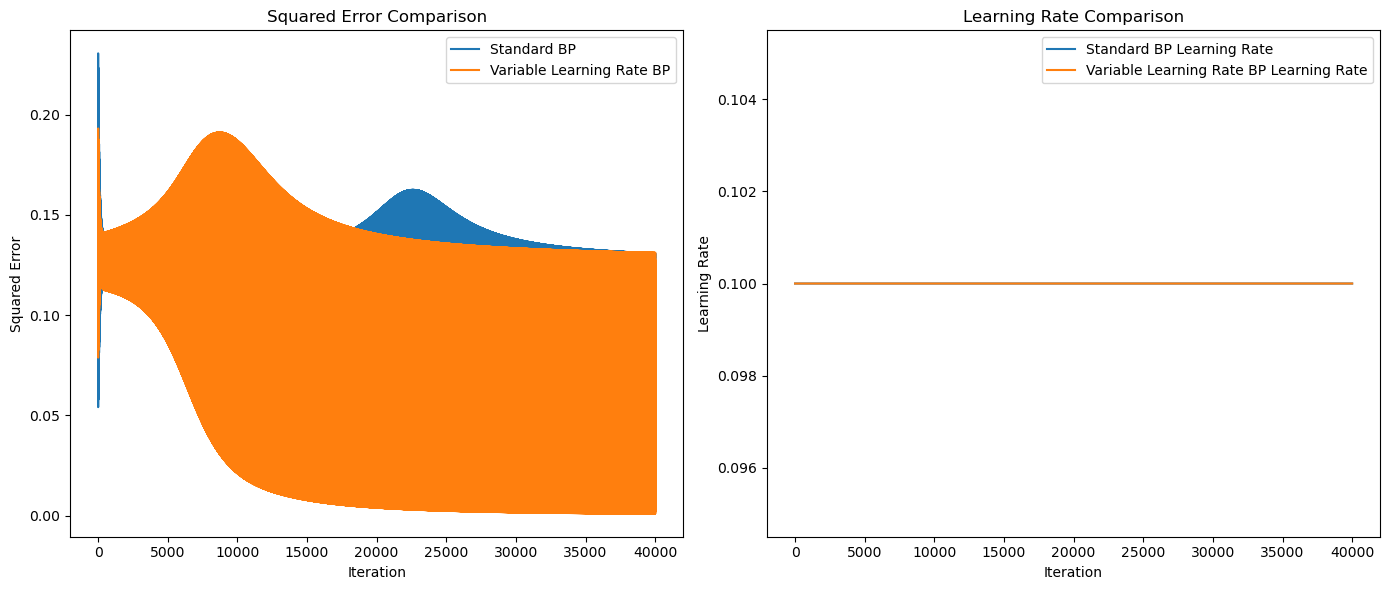

In [3]:
import random
import math
import matplotlib.pyplot as plt

# Sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Simple Neural Network Class
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # Initialize weights and biases
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.weights_input_hidden = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.weights_hidden_output = [[random.uniform(-1, 1) for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
        self.bias_output = [random.uniform(-1, 1) for _ in range(output_size)]
    
    # Forward pass
    def forward(self, x):
        self.hidden_layer = [sigmoid(sum(x[i] * self.weights_input_hidden[i][j] for i in range(self.input_size)) + self.bias_hidden[j]) for j in range(self.hidden_size)]
        self.final_output = [sigmoid(sum(self.hidden_layer[j] * self.weights_hidden_output[j][k] for j in range(self.hidden_size)) + self.bias_output[k]) for k in range(self.output_size)]
        return self.final_output
    
    # Standard Backpropagation
    def backpropagation(self, x, y):
        output_errors = [(y[0] - self.final_output[0]) * sigmoid_derivative(self.final_output[0])  # Adjusted for single output
                         ]
        hidden_errors = [sum(output_errors[k] * self.weights_hidden_output[j][k] for k in range(self.output_size)) * sigmoid_derivative(self.hidden_layer[j]) for j in range(self.hidden_size)]
        
        # Update weights and biases
        for j in range(self.hidden_size):
            for k in range(self.output_size):
                self.weights_hidden_output[j][k] += self.learning_rate * output_errors[k] * self.hidden_layer[j]
        
        for k in range(self.output_size):
            self.bias_output[k] += self.learning_rate * output_errors[k]
        
        for i in range(self.input_size):
            for j in range(self.hidden_size):
                self.weights_input_hidden[i][j] += self.learning_rate * hidden_errors[j] * x[i]
        
        for j in range(self.hidden_size):
            self.bias_hidden[j] += self.learning_rate * hidden_errors[j]
    
    # Variable Learning Rate Backpropagation
    def variable_learning_rate_backpropagation(self, x, y, zeta=0.04, rho=0.7, eta=1.05):
        # Calculate initial squared error
        prev_error = (y[0] - self.final_output[0]) ** 2 / 2  # Initial squared error based on single output
        
        self.backpropagation(x, y)  # Perform standard backpropagation
        
        # Calculate current squared error after weight update
        current_error = (y[0] - self.final_output[0]) ** 2 / 2  # Squared error after update
        
        # Variable Learning Rate Logic
        if current_error > prev_error * (1 + zeta):
            self.learning_rate *= rho  # Decrease learning rate
        elif current_error < prev_error:
            self.learning_rate *= eta  # Increase learning rate

# Dataset (XOR problem)
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
y = [[0], [1], [1], [0]]

# Initialize and train models
standard_nn = SimpleNN(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1)
variable_nn = SimpleNN(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1)

# Training parameters
epochs = 10000
standard_errors = []
variable_errors = []
standard_learning_rates = []
variable_learning_rates = []

for epoch in range(epochs):
    for i in range(len(X)):
        # Standard Backpropagation
        standard_nn.forward(X[i])
        standard_nn.backpropagation(X[i], y[i])
        standard_errors.append((y[i][0] - standard_nn.final_output[0]) ** 2 / 2)  # Corrected error calculation
        standard_learning_rates.append(standard_nn.learning_rate)

        # Variable Learning Rate Backpropagation
        variable_nn.forward(X[i])
        variable_nn.variable_learning_rate_backpropagation(X[i], y[i])
        variable_errors.append((y[i][0] - variable_nn.final_output[0]) ** 2 / 2)  # Corrected error calculation
        variable_learning_rates.append(variable_nn.learning_rate)

# Plotting
plt.figure(figsize=(14, 6))

# Squared Error Plot
plt.subplot(1, 2, 1)
plt.plot(standard_errors, label='Standard BP')
plt.plot(variable_errors, label='Variable Learning Rate BP')
plt.title('Squared Error Comparison')
plt.xlabel('Iteration')
plt.ylabel('Squared Error')
plt.legend()

# Learning Rate Plot
plt.subplot(1, 2, 2)
plt.plot(standard_learning_rates, label='Standard BP Learning Rate')
plt.plot(variable_learning_rates, label='Variable Learning Rate BP Learning Rate')
plt.title('Learning Rate Comparison')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()


# Numerical Optimization Techniques

Now that we have investigated some of the heuristic modifications to SDBP, let’s consider those methods that are based on standard numerical optimization techniques. We will investigate two techniques: **conjugate gradient** and **Levenberg-Marquardt**.

## Conjugate Gradient

The conjugate gradient algorithm for quadratic functions was presented in Chapter 9. We need to add two procedures to this algorithm in order to apply it to more general functions.

### Overview

In Chapter 9, we presented three numerical optimization techniques: steepest descent, conjugate gradient, and Newton’s method. Steepest descent is the simplest algorithm but is often slow in converging. Newton’s method is much faster but requires the calculation of the Hessian matrix and its inverse. The conjugate gradient algorithm is a compromise; it does not require the calculation of second derivatives and yet has the quadratic convergence property. It converges to the minimum of a quadratic function in a finite number of iterations.

### Conjugate Gradient Backpropagation (CGBP)

Let’s begin by reviewing the conjugate gradient algorithm. For ease of reference, we will repeat the algorithm steps from Chapter 9:

1. **Select the first search direction** $ p_0 $ to be the negative of the gradient:
   $$
   p_0 = -g_0,
   $$
   where
   $$
   g_k \equiv \nabla F(x) \quad (x = x_k)
   $$

2. **Take a step** according to:
   $$
   x_{k+1} = x_k + \alpha_k p_k,
   $$
   selecting the learning rate $ \alpha_k $ to minimize the function along the search direction.

3. **Select the next search direction** according to:
   $$
   p_k = -g_k + \beta_k p_{k-1},
   $$
   with
   $$
   \beta_k = \frac{\Delta g_{k-1}^T g_k}{\Delta g_{k-1}^T p_{k-1}} \quad \text{or} \quad \beta_k = \frac{g_k^T g_k}{g_{k-1}^T p_{k-1}} \quad \text{or} \quad \beta_k = \frac{g_k^T g_k}{g_k^T g_{k-1}}.
   $$

4. If the algorithm has not converged, continue from step 2.

### Application to Neural Networks

This conjugate gradient algorithm cannot be applied directly to the neural network training task because the performance index is not quadratic. This affects the algorithm in two ways:

- First, we cannot use the standard approach to minimize the function along a line.
- Second, the exact minimum will not normally be reached in a finite number of steps, and therefore the algorithm will need to be reset after some set number of iterations.

### Interval Location and Reduction

To locate the minimum of a function in a specified direction, we will involve two steps: **interval location** and **interval reduction**.

1. **Interval Location**: The purpose is to find some initial interval that contains a local minimum. This is done by evaluating the performance index at an initial point, $ x_0 $, and then evaluating at a second point, $ x_0 + \epsilon p_0 $.

  
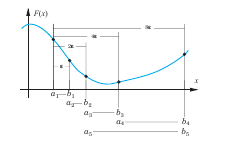
Figure.13 Interval Location


2. We continue evaluating at new points, $ b_i $, successively doubling the distance until the function increases between two consecutive evaluations. At this point, the minimum is bracketed by the two points $ a_5 $ and $ b_5 $.

3. **Interval Reduction**: After locating the interval, we reduce its size by evaluating the function at points inside the interval $ [a_5, b_5] $.

  
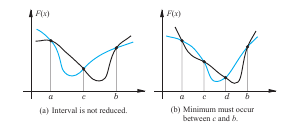

Figure.14 Reducing the Size of the Interval of Uncertainty

Evaluating the function at two internal points allows us to reduce the interval of uncertainty and locate the minimum more accurately.

## Conclusion

The conjugate gradient algorithm is an effective method for optimizing performance in neural network training. By adapting interval location and reduction techniques, we can enhance convergence and performance.





## Reducing the Size of the Interval of Uncertainty

If $ F(c) > F(d) $, as shown in Figure 12.14 (b), then the minimum must occur in the interval $ [c, b] $. Conversely, if $ F(c) < F(d) $, then the minimum must occur in the interval $ [a, d] $. (Note that we are assuming there is a single minimum located in the initial interval. More about that later.)

$$
F(x) \quad \text{(a) Interval is not reduced.}
$$

$$
F(x) \quad \text{(b) Minimum must occur between } c \text{ and } b.
$$

## Golden Section Search

The procedure described above suggests a method for reducing the size of the interval of uncertainty. We now need to decide how to determine the locations of the internal points $ c $ and $ d $. There are several ways to do this (see [Scal85]). We will use a method called the **Golden Section search**, which is designed to reduce the number of function evaluations required.

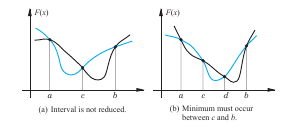

At each iteration, one new function evaluation is required. For example, in the case illustrated in Figure.14 (b), point $ a $ would be discarded, and point $ c $ would become the new $$ a $$. Then point $ d $ would become the new point $ c $, and a new $ d $ would be placed between the original points $ d $ and $ b $. The trick is to place the new point so that the interval of uncertainty will be reduced as quickly as possible.

### Algorithm for the Golden Section Search

The algorithm for the Golden Section search is as follows [Scal85]:

1. Set $ \tau = 0.618 $
2. Set $ c_1 = a_1 + (1 - \tau)(b_1 - a_1) $, $ F_c = F(c_1) $.
3. Set $ d_1 = b_1 - (1 - \tau)(b_1 - a_1) $, $ F_d = F(d_1) $.

For $ k = 1, 2, \ldots $ repeat:

- If $ F_c < F_d $ then
  - Set $ a_{k+1} = a_k $
  - Set $ b_{k+1} = d_k $
  - Set $ d_{k+1} = c_k $
  - Set $ c_{k+1} = a_{k+1} + (1 - \tau)(b_{k+1} - a_{k+1}) $
  - $ F_d = F_c $; $ F_c = F(c_{k+1}) $

- Else
  - Set $ a_{k+1} = c_k $
  - Set $ b_{k+1} = b_k $
  - Set $ c_{k+1} = d_k $
  - Set $ d_{k+1} = b_{k+1} - (1 - \tau)(b_{k+1} - a_{k+1}) $
  - $ F_c = F_d $; $ F_d = F(d_{k+1}) $

**End** 

Until $ b_{k+1} - a_{k+1} < \text{tol} $

Where $ \text{tol} $ is the accuracy tolerance set by the user.

### Modification to the Conjugate Gradient Algorithm

There is one more modification to the conjugate gradient algorithm that needs to be made before applying it to neural network training. For quadratic functions, the algorithm will converge to the minimum in at most $ n $ iterations, where $ n $ is the number of parameters being optimized. Since the mean squared error performance index for multilayer networks is not quadratic, the algorithm would not normally converge in $ n $ iterations.

The development of the conjugate gradient algorithm does not indicate what search direction to use once a cycle of $ n $ iterations has been completed. There have been many procedures suggested, but the simplest method is to reset the search direction to the steepest descent direction (negative of the gradient) after $ n $ iterations [Scal85]. 

### Application to Function Approximation

Let’s now apply the conjugate gradient algorithm to the function approximation example that we have been using to demonstrate the other neural network training algorithms. We will use the backpropagation algorithm to compute the gradient and the conjugate gradient algorithm to determine the weight updates. This is a batch mode algorithm, as the gradient is computed after the entire training set has been presented to the network.

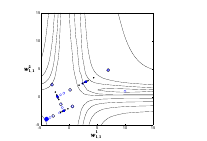

Figure 12.15 shows the intermediate steps of the CGBP algorithm for the first three iterations. The interval location process is illustrated by the open blue circles; each one represents one evaluation of the function. The final interval is indicated by the larger open black circles. The black dots indicate the location of the new interior points during the Golden Section search, one for each iteration of the procedure. The final point is indicated by a blue dot.

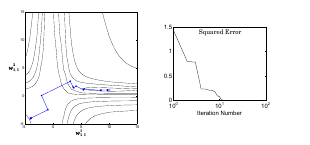

Figure.16 Conjugate Gradient Trajectory

Figure.16 shows the total trajectory to convergence. Notice that the CGBP algorithm converges in many fewer iterations than the other algorithms that we have tested. This is a little deceiving since each iteration of CGBP requires more computations than the other methods; there are many function evaluations involved in each iteration of CGBP. Even so, CGBP has been shown to be one of the fastest batch training algorithms for multilayer networks [Char92].



Epoch 0, Loss: 0.2938
Epoch 100, Loss: 0.1308
Epoch 200, Loss: 0.1261
Epoch 300, Loss: 0.1260
Epoch 400, Loss: 0.1260
Epoch 500, Loss: 0.1260
Epoch 600, Loss: 0.1261
Epoch 700, Loss: 0.1261
Epoch 800, Loss: 0.1261
Epoch 900, Loss: 0.1262


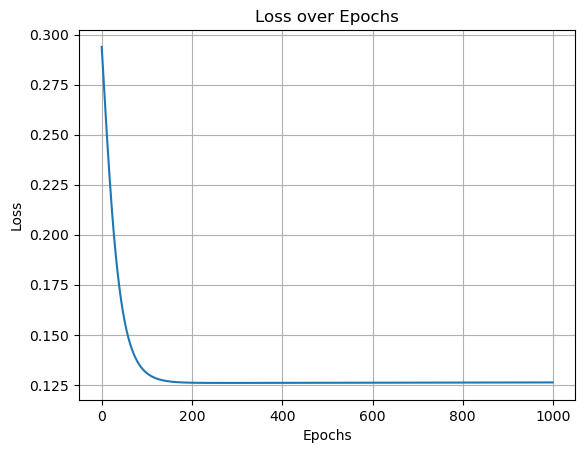

In [9]:
import random
import math
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize the network with random weights and biases
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Random weights and biases for input to hidden layer
        self.weights_input_hidden = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.bias_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
        
        # Random weights and biases for hidden to output layer
        self.weights_hidden_output = [[random.uniform(-1, 1) for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_output = [random.uniform(-1, 1) for _ in range(output_size)]
        
        # Store the final output and gradients
        self.final_output = [0] * output_size
        self.gradients_output = [0] * output_size
        self.gradients_hidden = [0] * hidden_size

    def sigmoid(self, x):
        """Activation function: Sigmoid"""
        return 1 / (1 + math.exp(-x))

    def sigmoid_derivative(self, x):
        """Derivative of the sigmoid function"""
        return x * (1 - x)

    def forward(self, x):
        """Forward propagation"""
        self.hidden_layer_activation = [0] * self.hidden_size
        for j in range(self.hidden_size):
            self.hidden_layer_activation[j] = self.sigmoid(sum(x[i] * self.weights_input_hidden[i][j] for i in range(self.input_size)) + self.bias_hidden[j])
        
        for k in range(self.output_size):
            self.final_output[k] = self.sigmoid(sum(self.hidden_layer_activation[j] * self.weights_hidden_output[j][k] for j in range(self.hidden_size)) + self.bias_output[k])

    def compute_loss(self, y):
        """Mean Squared Error Loss"""
        return sum((y[i] - self.final_output[i]) ** 2 for i in range(self.output_size)) / 2

    def backpropagation(self, x, y, learning_rate=0.1):
        """Backward propagation to adjust weights and biases"""
        # Calculate output layer error and gradients
        for k in range(self.output_size):
            error = y[k] - self.final_output[k]
            self.gradients_output[k] = error * self.sigmoid_derivative(self.final_output[k])

        # Calculate hidden layer error and gradients
        for j in range(self.hidden_size):
            error = sum(self.gradients_output[k] * self.weights_hidden_output[j][k] for k in range(self.output_size))
            self.gradients_hidden[j] = error * self.sigmoid_derivative(self.hidden_layer_activation[j])

        # Update weights and biases for hidden to output layer
        for j in range(self.hidden_size):
            for k in range(self.output_size):
                self.weights_hidden_output[j][k] += learning_rate * self.gradients_output[k] * self.hidden_layer_activation[j]

        for k in range(self.output_size):
            self.bias_output[k] += learning_rate * self.gradients_output[k]

        # Update weights and biases for input to hidden layer
        for i in range(self.input_size):
            for j in range(self.hidden_size):
                self.weights_input_hidden[i][j] += learning_rate * self.gradients_hidden[j] * x[i]

        for j in range(self.hidden_size):
            self.bias_hidden[j] += learning_rate * self.gradients_hidden[j]

    def train(self, x_train, y_train, epochs=1000, learning_rate=0.1):
        """Train the neural network"""
        loss_history = []  # To store the loss values
        for epoch in range(epochs):
            for x, y in zip(x_train, y_train):
                self.forward(x)  # Forward pass
                self.backpropagation(x, y, learning_rate)  # Backward pass
            
            # Compute loss for the first training example and store it
            loss = self.compute_loss(y_train[0])
            loss_history.append(loss)
            
            if epoch % 100 == 0:  # Print loss every 100 epochs
                print(f'Epoch {epoch}, Loss: {loss:.4f}')
        
        # Plot the loss over epochs
        plt.plot(loss_history)
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

# Example usage
if __name__ == "__main__":
    # Define input size, hidden size, and output size
    input_size = 2
    hidden_size = 2
    output_size = 1
    
    # Create an instance of the neural network
    nn = NeuralNetwork(input_size, hidden_size, output_size)
    
    # Example training data (XOR problem)
    x_train = [[0, 0], [0, 1], [1, 0], [1, 1]]
    y_train = [[0], [1], [1], [0]]
    
    # Train the neural network
    nn.train(x_train, y_train, epochs=1000, learning_rate=0.1)


In [10]:
import numpy as np

class ConjugateGradient:
    def __init__(self, func, grad, max_iterations=1000, tol=1e-6):
        """
        Initialize the Conjugate Gradient optimizer.

        :param func: The objective function to minimize.
        :param grad: The gradient of the objective function.
        :param max_iterations: Maximum number of iterations.
        :param tol: Tolerance for stopping criteria.
        """
        self.func = func
        self.grad = grad
        self.max_iterations = max_iterations
        self.tol = tol

    def optimize(self, x0):
        """
        Optimize the objective function using the Conjugate Gradient method.

        :param x0: Initial guess for the variables.
        :return: The optimal solution and the function value at that point.
        """
        x = x0
        r = self.grad(x)  # Initial residual
        p = -r  # Initial search direction
        rsold = np.dot(r, r)

        for iteration in range(self.max_iterations):
            Ap = self.hessian_vector_product(p)  # Hessian-vector product
            alpha = rsold / np.dot(p, Ap)  # Step size
            x = x + alpha * p  # Update the solution
            r = r + alpha * Ap  # Update the residual
            rsnew = np.dot(r, r)

            if np.sqrt(rsnew) < self.tol:  # Check for convergence
                print(f'Converged after {iteration} iterations.')
                return x, self.func(x)

            p = -r + (rsnew / rsold) * p  # Update the search direction
            rsold = rsnew

        print('Maximum iterations reached.')
        return x, self.func(x)

    def hessian_vector_product(self, v):
        """
        Compute the product of the Hessian matrix and a vector v.

        :param v: The vector to multiply with the Hessian.
        :return: The resulting vector.
        """
        # Assuming the objective function is a quadratic function
        return self.grad(v)  # Placeholder for Hessian-vector product

# Example usage
if __name__ == "__main__":
    # Define a simple quadratic function and its gradient
    def func(x):
        return 0.5 * np.dot(x, x)  # f(x) = 0.5 * ||x||^2

    def grad(x):
        return x  # f'(x) = x

    # Initial guess
    x0 = np.array([3.0, 4.0])

    # Create an instance of the Conjugate Gradient optimizer
    optimizer = ConjugateGradient(func, grad)

    # Optimize the function
    optimal_x, optimal_value = optimizer.optimize(x0)

    print(f'Optimal solution: {optimal_x}, Function value: {optimal_value}')


Converged after 0 iterations.
Optimal solution: [0. 0.], Function value: 0.0
